In [1]:
#Imports
import base64
import sys
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import pyvisa
import logging
from time import sleep
from toptica.lasersdk.client import Client, SerialConnection, UserLevel, Subscription, Timestamp, SubscriptionValue

In [2]:
#Configuration Variables
log_file = "../Data/Baseline_Daily/Logs/baseline2_7-16-24.log" #name of log file
plot_file = '../Data/Baseline_Daily/Plots/baseline2_7-16-24.png' #name of plot file
csv_file = '../Data/Baseline_Daily/Tables/baseline2_7-16-24.csv' #name of csv file
warm_up_time = 0 #In seconds, how long PROWLS should wait at desired settings before taking data
power_down = False #True or False, if PROWLS should power down after data acquisition
lockin_address = 'GPIB::8::INSTR' #connection to DLC Smart
dlc_connection_port = 'COM3' #connection to lock-in amplifier
bias_frequency = 1000 #in Hz, the bias frequency of DLC Smart and the lock-in amplifier
sensitivity_setting = 16 #lock-in sensitivity setting, specifics found in SR830 manual 
set_frequency = 180 #in GHz, the desired frequency of the DLC Smart to measure at 
time_constant = 8 #lock-in time constant setting, specifics found in SR830 manual
low_pass_filter = 0 #lock-in low pass filter slope setting, specifics found in SR830 manual
sampling_rate = 50 #in samples/second, the sampling rate
total_duration = 1800 #in seconds, how long PROWLS will take data for
time_interval = 1/sampling_rate

In [3]:
#Ensure directories exist for files
for file_path in [log_file, plot_file, csv_file]:
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
#Configure logging
logging.basicConfig(filename = log_file, level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
def log_and_print(message):
    logging.info(message)
    print(message)

In [5]:
#Set up connection with lock-in amplifier
rm = pyvisa.ResourceManager()
lockin = rm.open_resource(lockin_address)
idn = lockin.query('*IDN?')
log_and_print(f'Connected to: {idn}')

Connected to: 0.000114352



In [6]:
#Set up connection with DLC smart and check user level
with Client(SerialConnection(dlc_connection_port)) as client:
    user_level = client.get('ul')
    dlc_smart = client.get('general:system-type')
    log_and_print(f'Connected to: {dlc_smart}')
    log_and_print(f"Current User Level: {user_level}")

Connected to: DLCsmartTHz
Current User Level: 3


In [7]:
#Turn on lasers (check emission lights)
#If lasers do not power on, check the frontkey and user level
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('laser-operation:emission-global-enable', True)
    log_and_print(f'Lasers on: {client.get('laser-operation:emission-global-enable')}')
#Wait 5 seconds for lasers to adjust
time.sleep(5)

Lasers on: True


In [8]:
#Set DLC Smart bias amplitude (0.8V), offset (-0.30V), and frequency
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('lockin:mod-out-amplitude', 0.80) 
    client.set('lockin:mod-out-offset', -0.30)
    client.set('lockin:frequency', bias_frequency)
    log_and_print(f"Current DLC Smart Bias Amplitude (V): {client.get('lockin:mod-out-amplitude')}")
    log_and_print(f"Current DLC Smart Bias Offset (V): {client.get('lockin:mod-out-offset')}")
    log_and_print(f"Current DLC Smart Bias Frequency (Hz): {client.get('lockin:frequency')}")
#wait 5 seconds for DLC smart to adjust
time.sleep(5)

Current DLC Smart Bias Amplitude (V): 0.800018310546875
Current DLC Smart Bias Offset (V): -0.30002441704309607
Current DLC Smart Bias Frequency (Hz): 1000


In [9]:
#Set laser frequency
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('frequency:frequency-set', set_frequency)
    log_and_print(f"Current Laser Frequency (GHz): {client.get('frequency:frequency-act')}")

Current Laser Frequency (GHz): 179.99884283650317


In [10]:
#Set lock-in sensitivity, time constant, low pass filter, and bias frequency
lockin.write(f'SENS {sensitivity_setting}')
lockin.write(f'OFLT {time_constant}')
lockin.write(f'OFSL {low_pass_filter}')
lockin.write(f'FREQ {bias_frequency}')
log_and_print(f"Current Lock-in Sensitivity setting: {lockin.query('SENS?')}")
log_and_print(f'Current Time Constant: {lockin.query('OFLT?')}')
log_and_print(f'Current Low Pass Filter: {lockin.query('OFSL?')}')
log_and_print(f"Current Lock-in Bias Frequency (Hz): {lockin.query('FREQ?')}")

Current Lock-in Sensitivity setting: Stanford_Research_Systems,SR830,s/n46458,ver1.07 

Current Time Constant: 16

Current Low Pass Filter: 8

Current Lock-in Bias Frequency (Hz): 0



In [11]:
#Wait the warm-up time
log_and_print(f'Waiting the {warm_up_time} second warm-up time')
time.sleep(warm_up_time)

Waiting the 0 second warm-up time


In [12]:
#Empty dataframe
data = {'Time': [], 'Vlockin (microvolts)': []}

In [13]:
#Collect time vs. vlockin data
log_and_print(f'Sampling Rate (samples/second): {sampling_rate}')
log_and_print(f'Total Duration (seconds): {total_duration}')
log_and_print(f'Time Interval (seconds): {time_interval}')
log_and_print('BEGINNING DATA ACQUISITION')
start_time = time.time()
next_sample_time = start_time
while time.time() - start_time < total_duration:
    #Get the current time
    current_time = time.time() - start_time
    #Get vlockin
    vlockin = float(lockin.query('OUTP?3')) * 1e6
    #Append data
    data['Time'].append(current_time)
    data['Vlockin (microvolts)'].append(vlockin)
    #Calculate the time for the next sample
    next_sample_time += time_interval
    sleep_time = next_sample_time - time.time()
    #Wait for next sample
    if sleep_time > 0:
        time.sleep(sleep_time)
log_and_print('DATA ACQUISITION COMPLETE')

Sampling Rate (samples/second): 50
Total Duration (seconds): 1800
Time Interval (seconds): 0.02
BEGINNING DATA ACQUISITION
DATA ACQUISITION COMPLETE


In [18]:
#Save to csv
df = pd.DataFrame(data)
df = df.drop(index=0)
df.to_csv(csv_file, index = False)
log_and_print(f"The data has been saved to {csv_file}, previous file may have been overwritten.")
pd.read_csv(csv_file)

The data has been saved to ../Data/Baseline_Daily/Tables/baseline2_7-16-24.csv, previous file may have been overwritten.


,Time,Vlockin (microvolts)
0,0.021243,114.024
1,0.046056,113.219
2,0.060855,113.965
3,0.084093,113.458
4,0.100752,114.143
...,...,...
89994,1799.903151,114.173
89995,1799.918774,113.130
89996,1799.938851,113.369
89997,1799.958577,113.518


The data has been saved to ../Data/Baseline_Daily/Plots/baseline2_7-16-24.png, previous file may have been overwritten.


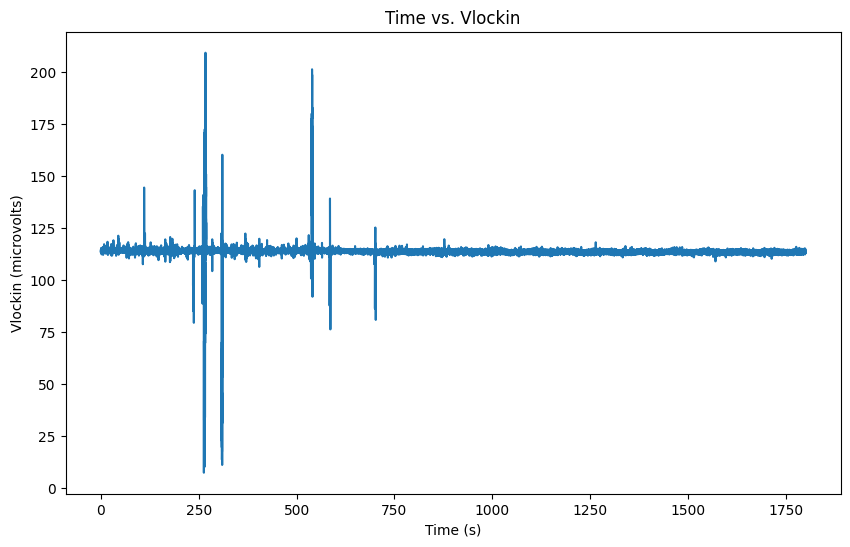

In [19]:
#Plot time vs. vlockin
plt.figure(figsize = (10, 6))
plt.plot(df['Time'], df['Vlockin (microvolts)'])
plt.xlabel('Time (s)')
plt.ylabel('Vlockin (microvolts)')
plt.title('Time vs. Vlockin')
plt.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
#save to png
plt.savefig(plot_file)
log_and_print(f"The data has been saved to {plot_file}, previous file may have been overwritten.")
#display the plot
plt.show()

In [16]:
#Either power down PROWLS and turn off bias amplitude, bias offset, and lasers, or keep them all on.
with Client(SerialConnection(dlc_connection_port)) as client:
    if power_down:
        client.set('lockin:mod-out-amplitude', 0)
        client.set('lockin:mod-out-offset', 0)
        #wait 5 secs for DLC smart to adjust
        time.sleep(5)
        client.set('laser-operation:emission-global-enable', False)
        log_and_print(f"PROWLS powered down")
    else:
        log_and_print(f"PROWLS did NOT power down")
    log_and_print(f"Current DLC Smart Bias Amplitude (V): {client.get('lockin:mod-out-amplitude')}")
    log_and_print(f"Current DLC Smart Bias Offset (V): {client.get('lockin:mod-out-offset')}")
    log_and_print(f'Lasers on: {client.get('laser-operation:emission-global-enable')}')

PROWLS did NOT power down
Current DLC Smart Bias Amplitude (V): 0.800018310546875
Current DLC Smart Bias Offset (V): -0.30002441704309607
Lasers on: True
